In [166]:
import time

import tensorflow as tf
import matplotlib.pyplot as plt

In [167]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [168]:
def load_image(path):
    encoded_img = tf.io.read_file(path)
    img = tf.image.decode_image(encoded_img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) # 從[0, 255]標準化到[0, 1]
    img = tf.image.resize(img, (288, 350)) # 縮小尺寸加速訓練
    return img

content_img = load_image(content_path)
style_img = load_image(style_path)

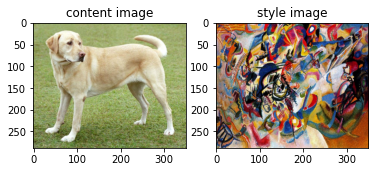

In [169]:
plt.subplot(1, 2, 1)
plt.title('content image')
plt.imshow(content_img)
plt.subplot(1, 2, 2)
plt.title('style image')
plt.imshow(style_img)

In [170]:
# 從(...)升維到(1, ...)
content_img = content_img[tf.newaxis, ...]
style_img = style_img[tf.newaxis, ...]

In [171]:
vgg19 = tf.keras.applications.VGG19(include_top=False, 
                                    weights='imagenet')
for layer in vgg19.layers:
    print(layer.name)

input_17
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [172]:
class Extractor(tf.keras.models.Model):
    def __init__(self):
        super().__init__()
        # 使模型輸出多個特徵層的特徵
        vgg19 = tf.keras.applications.VGG19(include_top=False, 
                                            weights='imagenet')
        vgg19.trainable = False
        inputs = [vgg19.input]
        outputs = [layer.output for layer in vgg19.layers if self._is_interested_layer(layer)]
        self.model = tf.keras.Model(inputs, outputs)
        self.model.trainable = False
    
    def _is_interested_layer(self, layer):
        if layer.name.endswith('conv1') or layer.name == 'block5_conv2':
            return True
    
    def _gram_matrix(self, feature):
        outproduct = tf.linalg.einsum('bijc,bijd->bcd', feature, feature)
        num_locations = feature.shape[1] * feature.shape[2]
        return outproduct / num_locations

    def call(self, inputs):
        inputs = inputs * 255. # 輸入區間是[0, 1]
        inputs = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.model(inputs)
        content_feature = outputs[-1] # 最後一個輸出
        style_features = outputs[:-1] # 前五個輸出
        style_features = list(map(self._gram_matrix, style_features))
        return content_feature, style_features

In [173]:
extractor = Extractor()
content_target, _ = extractor(content_img)
_, style_targets = extractor(style_img)

In [174]:
opt = tf.optimizers.Adam(.02, beta_1=.99, epsilon=.1)

In [175]:
style_weight = 1e-2
content_weight = 1e4
total_variation_weight = 30

In [176]:
def content_style_loss(content_feature, style_features):
    content_loss = tf.reduce_mean((content_feature - content_target) ** 2)
    style_loss = tf.add_n([tf.reduce_mean((style_feature - style_target) ** 2 )
                           for style_feature, style_target in zip(style_features, style_targets)]) / 5
    total_loss = content_weight * content_loss + style_weight * style_loss
    return total_loss

In [177]:
@tf.function
def train_step(img):
    with tf.GradientTape() as tape:
        content_feature, style_features = extractor(img)
        loss = content_style_loss(content_feature, style_features)
        loss += total_variation_weight * tf.image.total_variation(img)
    
    grad = tape.gradient(loss, img)
    opt.apply_gradients([(grad, img)])
    img.assign(tf.clip_by_value(img, 0., 1.))

In [178]:
img = tf.Variable(content_img)

In [182]:
steps = 1000
history = {}
for step in range(steps):
    start = time.time()
    train_step(img)
    end = time.time()
    duration = end - start
    history[step] = img[0, ...] # 降維方便顯示
    print(f"step: {step}, duration: {duration:.1f}s")

step: 100, duration: 0.8s
step: 101, duration: 0.8s
step: 102, duration: 0.8s
step: 103, duration: 0.8s
step: 104, duration: 0.8s
step: 105, duration: 0.8s
step: 106, duration: 0.8s
step: 107, duration: 0.8s
step: 108, duration: 0.8s
step: 109, duration: 0.8s
step: 110, duration: 0.8s
step: 111, duration: 0.8s
step: 112, duration: 0.8s
step: 113, duration: 0.8s
step: 114, duration: 0.8s
step: 115, duration: 0.8s
step: 116, duration: 0.8s
step: 117, duration: 0.8s
step: 118, duration: 0.9s
step: 119, duration: 0.8s
step: 120, duration: 0.8s
step: 121, duration: 0.8s
step: 122, duration: 0.8s
step: 123, duration: 0.8s
step: 124, duration: 0.8s
step: 125, duration: 0.8s
step: 126, duration: 0.8s
step: 127, duration: 0.8s
step: 128, duration: 0.9s
step: 129, duration: 0.8s
step: 130, duration: 0.9s
step: 131, duration: 0.8s
step: 132, duration: 0.8s
step: 133, duration: 0.9s
step: 134, duration: 0.9s
step: 135, duration: 0.9s
step: 136, duration: 0.8s
step: 137, duration: 0.8s
step: 138, d

step: 416, duration: 0.8s
step: 417, duration: 0.8s
step: 418, duration: 0.8s
step: 419, duration: 0.8s
step: 420, duration: 0.8s
step: 421, duration: 0.8s
step: 422, duration: 0.8s
step: 423, duration: 0.7s
step: 424, duration: 0.8s
step: 425, duration: 0.8s
step: 426, duration: 0.8s
step: 427, duration: 0.8s
step: 428, duration: 0.8s
step: 429, duration: 0.8s
step: 430, duration: 0.8s
step: 431, duration: 0.8s
step: 432, duration: 0.8s
step: 433, duration: 0.8s
step: 434, duration: 0.8s
step: 435, duration: 0.8s
step: 436, duration: 0.8s
step: 437, duration: 0.8s
step: 438, duration: 0.8s
step: 439, duration: 0.8s
step: 440, duration: 0.8s
step: 441, duration: 0.8s
step: 442, duration: 0.8s
step: 443, duration: 0.8s
step: 444, duration: 0.8s
step: 445, duration: 0.8s
step: 446, duration: 0.8s
step: 447, duration: 0.8s
step: 448, duration: 0.8s
step: 449, duration: 0.8s
step: 450, duration: 0.8s
step: 451, duration: 0.8s
step: 452, duration: 0.8s
step: 453, duration: 0.8s
step: 454, d

step: 732, duration: 0.8s
step: 733, duration: 0.8s
step: 734, duration: 0.8s
step: 735, duration: 0.8s
step: 736, duration: 0.8s
step: 737, duration: 0.8s
step: 738, duration: 0.8s
step: 739, duration: 0.8s
step: 740, duration: 0.8s
step: 741, duration: 0.8s
step: 742, duration: 0.8s
step: 743, duration: 0.8s
step: 744, duration: 0.8s
step: 745, duration: 0.8s
step: 746, duration: 0.8s
step: 747, duration: 0.8s
step: 748, duration: 0.8s
step: 749, duration: 0.8s
step: 750, duration: 0.8s
step: 751, duration: 0.8s
step: 752, duration: 0.8s
step: 753, duration: 0.8s
step: 754, duration: 0.8s
step: 755, duration: 0.8s
step: 756, duration: 0.8s
step: 757, duration: 0.8s
step: 758, duration: 0.8s
step: 759, duration: 0.8s
step: 760, duration: 0.8s
step: 761, duration: 0.8s
step: 762, duration: 0.8s
step: 763, duration: 0.8s
step: 764, duration: 0.8s
step: 765, duration: 0.8s
step: 766, duration: 0.8s
step: 767, duration: 0.8s
step: 768, duration: 0.8s
step: 769, duration: 0.8s
step: 770, d

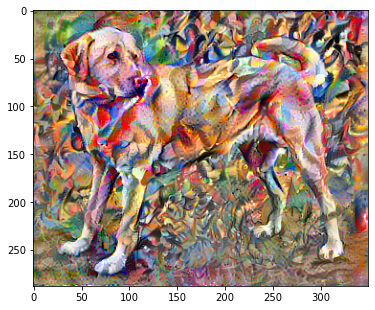

In [191]:
plt.figure(figsize=(6, 6))
plt.imshow(history[999])